# Autoencoding Graphical User Interfaces

In our initial approach to solving code2pix, we assumed we needed to pretrain a convolutional model that could decode textual data into images of graphical user interfaces. The purpose of training the following autoencoder is to train the decoder that we then use in the code2pix model. However, last minute experiments showed that training the autoencoder is **not strictly necessary** to train code2pix. If you would like to skip straight to code2pix, feel free to initialize the model, skip training, and just save the model for its architecture. Code2Pix will just needs the layer architecture constructed in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
% matplotlib inline
import os
from os.path import join

import keras
from keras.models import Sequential
from keras.layers import (LSTM, Dense, Conv2D, Input, Reshape, concatenate, MaxPooling2D,Dropout, Flatten, 
RepeatVector, UpSampling2D, Conv1D, Permute, BatchNormalization, Activation, UpSampling2D)
from keras import Model
from keras.engine.topology import Layer, InputSpec
from keras import backend as K
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.losses import mean_squared_error
from keras.preprocessing import sequence

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Hydra Autoencoder

Model that understands our synthetic datasets (android, ios, web) interfaces, using a shared CNN to encode each picture, and unique heads to decode for each platform (3 heads). It takes about 15 minutes to train all three heads and the encoder on two Nvidia 1080 Ti-s.

In [2]:
def load_guis(data_dir):
    """Loads in target data (picture data) in a given directory.
    Returns a np.array of the data loaded."""
    GUIS = []
    training_GUI_listing = os.listdir(data_dir)
    for listing in training_GUI_listing:
        if listing.endswith('.npz'):
            temp = np.load(join(data_dir, listing))['features']
            # reshape to be flat
            GUIS += [temp]
    GUIS = np.array(GUIS)
    return GUIS

def make_head():
    """Returns a standard decoder model"""
    input_layer = Input(shape=(16, 16, 16))
    last = Conv2D(128, (4, 4), padding='same', activation='relu')(input_layer)

    last = BatchNormalization()(last)
    last = UpSampling2D(size=(2, 2))(last)
    last = Conv2D(96, (3, 3), padding='same', activation='relu')(last)
    # model.add(Conv2DTranspose(96, (2, 2), strides=(2, 2)))
    last = BatchNormalization()(last)
    last = UpSampling2D(size=(4, 4))(last)
    last = Conv2D(32, (3, 3), padding='same', activation='relu')(last)
    # model.add(Conv2DTranspose(32, (2, 2), strides=(2, 2)))
    last = BatchNormalization()(last)
    last = UpSampling2D(size=(2, 2))(last)
    # model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    last = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(last)
    # model.add(Conv2DTranspose(color, (3, 3), strides=(2, 2)))
    model = Model(input_layer, last)
    return model
    
def make_hydra(loss='binary_crossentropy', optimizer='rmsprop'):
    """Creates 3 headed autoencoder model to handle the different datasets.
    Returns [android, ios, web] models"""
    keras.backend.clear_session()

    input_layer = Input(shape=(256, 256, 3))
    drop_rate = 0.25
    last = Conv2D(64, (5, 5), strides=(2,2), activation='relu')(input_layer)
    last = Conv2D(128, (4, 4), padding='same', strides=(1,1), activation='relu')(last)
    last = MaxPooling2D(pool_size=(2,2))(last)
    last = Dropout(drop_rate)(last)
    last = Conv2D(128, (4, 4), padding='same', strides=(2,2), activation='relu')(last)
    last = Conv2D(256, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = MaxPooling2D(pool_size=(2, 2))(last)
    last = Dropout(drop_rate)(last)

    last = Conv2D(128, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu')(last)
    last = Conv2D(16, (3, 3), padding='same', strides=(1,1), activation='relu')(last)

    encoder = Model(input_layer, last)
    android = make_head()
    ios = make_head()
    web = make_head()
    
    models = []
    for model in [android, ios, web]:
        head_spout = model(encoder.output)
        head = Model(input_layer, head_spout)
        head.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        models.append(head)
    return models

def train_hydra(epochs, models, datasets, val_split=0.2):
    """Assumes models=[android, ios, web], and datasets ordered alphabetically as well.
    Trains the models sequentially, 1 epoch after the other. Validation split is last
    val_split % of the data.
    
    ~16 epochs seems to give good perf, >30 pretty good"""
    train = [data[:int((1 - val_split)*len(data))] for data in datasets]
    validation = [data[int((1-val_split)*len(data)):] for data in datasets]
    val_loss = 20
    val_best = 20
    for i in range(epochs):
        print("Epoch: {}".format(i+1))
        val_loss = 0
        for model, data, val in zip(models, train, validation):
            model.fit(data, data, batch_size=16, validation_data=(val, val))
            val_loss += model.evaluate(val, val)[0]
        print("Model had avg val loss of: {}".format(val_loss / 3))
        if val_loss < val_best:
            val_best = val_loss / 3
        print("Best avg validation loss is {}".format(val_best))
            
android_data = load_guis('android/training_features/')
ios_data = load_guis('ios/training_features/')
web_data = load_guis('web/training_features/')
models = make_hydra()
train_hydra(28, models, [android_data, ios_data, web_data])

Epoch: 1
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 4ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Model had avg val loss of: 0.43409594668282403
Best avg validation loss is 0.43409594668282403
Epoch: 2
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Model had avg val loss of: 0.22908878293302326
Best avg validation loss is 0.43409594668282403
Epoch: 3
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step

300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Model had avg val loss of: 0.2672271705998315
Best avg validation loss is 0.43409594668282403
Epoch: 12
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Model had avg val loss of: 0.20082141041755674
Best avg validation loss is 0.43409594668282403
Epoch: 13
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300

300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Model had avg val loss of: 0.15858489149146607
Best avg validation loss is 0.43409594668282403
Epoch: 22
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Model had avg val loss of: 0.1565568486849467
Best avg validation loss is 0.43409594668282403
Epoch: 23
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300 [==============================] - 1s 3ms/step
Train on 1200 samples, validate on 300 samples
Epoch 1/1
300/300

Visualizing the models' performance. Example visualizations are saved in `android_hydra.png`, `ios_hydra.png`, and `web_hydra.png` respectively. To change which pictures are shown, modify the `idx` argument passed to predict. Should be between \[0, len(data) = 1500).

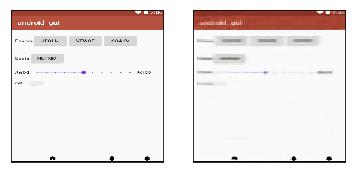

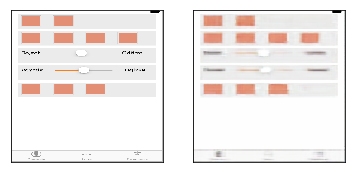

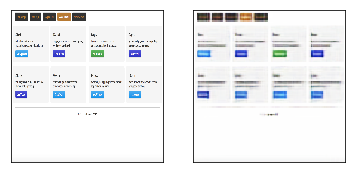

In [3]:
def predict(model, dataset, idx, name):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(dataset[idx])
    axes[1].imshow(model.predict(np.expand_dims(dataset[idx], 0))[0])
    for ax in axes:
        ax.set_yticks([])
        ax.set_xticks([])
        
    fig.savefig(name, dpi=70)
    plt.show()

for model, data, name in zip(models, [android_data, ios_data, web_data], ['android', 'ios', 'web']):
    predict(model, data, 100, '{}_hydra.png'.format(name))
    model.save('{}-hydra-model'.format(name))

Verifying that the models saved properly

In [4]:
% ls *-model

android-hydra-model  ios-hydra-model  web-hydra-model
